<a href="https://colab.research.google.com/github/Saeeeae/Pytorch-Studying/blob/master/torch_cat_dog_kaggle_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### dataloader 다시짜기 kaggle보던가
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
import argparse
import csv
import os.path
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image

from google.colab import drive

drive.mount('/content/gdrive')

### Reference Code
# https://www.kaggle.com/jaeboklee/pytorch-cat-vs-dog

### kaggle dataset을 colab으로 옮겨주는 방법
# https://medium.com/hyunjulie/%EC%BA%90%EA%B8%80%EA%B3%BC-%EA%B5%AC%EA%B8%80-colab-%EC%97%B0%EA%B2%B0%ED%95%B4%EC%A3%BC%EA%B8%B0-6a274f6de81d

### dataloader에서 num_worker의 역할 (cpu, gpu에서의 분산처리를 통한 데이터 처리 향상)
# https://jybaek.tistory.com/799

# 이후 content에서 zip파일을 unzip해주고 해당 폴더를 rm abc /content/gdrive/My\ Drive/Colab\ Notebooks/
# 로 옮겨주면 됨

# train_dir = os.path.join('gdrive/My Drive/Colab Notebooks/cat_dog_torch_200109','train/')
# test_dir = os.path.join('gdrive/My Drive/Colab Notebooks/cat_dog_torch_200109','test1/')
train_dir = 'gdrive/My Drive/Colab Notebooks/cat_dog_torch_200109/train'
test_dir = 'gdrive/My Drive/Colab Notebooks/cat_dog_torch_200109/test1'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform

        if self.mode =='train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

data_transform = transforms.Compose([
                                     transforms.Resize(256), transforms.ColorJitter(), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(), transforms.Resize(128), transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]
print(cat_files)
print(dog_files)

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)
print(cats.__len__())
print(dogs.__len__())

catdogs = ConcatDataset([cats, dogs])
print(catdogs.__len__())

['cat.9067.jpg', 'cat.9114.jpg', 'cat.9094.jpg', 'cat.9108.jpg', 'cat.9081.jpg', 'cat.9090.jpg', 'cat.912.jpg', 'cat.9079.jpg', 'cat.9104.jpg', 'cat.9092.jpg', 'cat.9066.jpg', 'cat.907.jpg', 'cat.9088.jpg', 'cat.9096.jpg', 'cat.9102.jpg', 'cat.9071.jpg', 'cat.9073.jpg', 'cat.9116.jpg', 'cat.9113.jpg', 'cat.9099.jpg', 'cat.908.jpg', 'cat.9089.jpg', 'cat.909.jpg', 'cat.9093.jpg', 'cat.9123.jpg', 'cat.9072.jpg', 'cat.9117.jpg', 'cat.9119.jpg', 'cat.9080.jpg', 'cat.9179.jpg', 'cat.9126.jpg', 'cat.9141.jpg', 'cat.9175.jpg', 'cat.9125.jpg', 'cat.9130.jpg', 'cat.9160.jpg', 'cat.9148.jpg', 'cat.9131.jpg', 'cat.9153.jpg', 'cat.9165.jpg', 'cat.9134.jpg', 'cat.9133.jpg', 'cat.9136.jpg', 'cat.914.jpg', 'cat.9145.jpg', 'cat.9124.jpg', 'cat.9157.jpg', 'cat.9166.jpg', 'cat.913.jpg', 'cat.9176.jpg', 'cat.9128.jpg', 'cat.9178.jpg', 'cat.9127.jpg', 'cat.9167.jpg', 'cat.9147.jpg', 'cat.9143.jpg', 'cat.9164.jpg', 'cat.9169.jpg', 'cat.9139.jpg', 'cat.9177.jpg', 'cat.9150.jpg', 'cat.9168.jpg', 'cat.9159.jpg

In [0]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle = True, num_workers = 4)


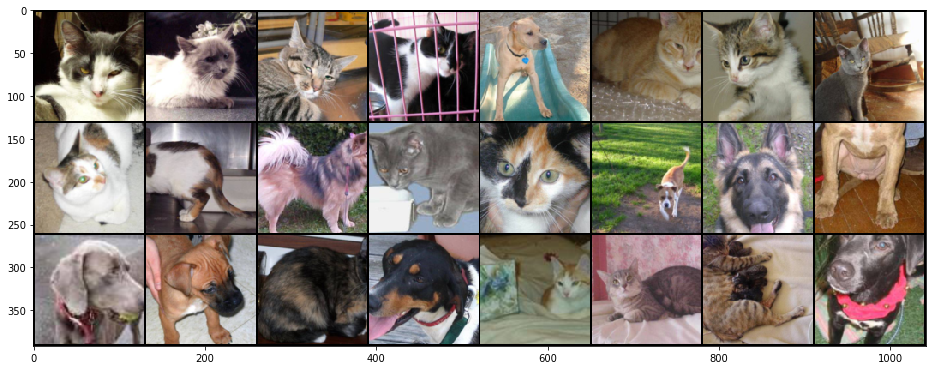

In [0]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [0]:
class net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(32,64, 3)
        self.conv3 = nn.Conv2d(64,128,5)
        self.conv4 = nn.Conv2d(128, 256,5)

        self.fc1 = nn.Linear(21*21*256, 2)
        #self.fc2 = nn.Linear(512, 128)
        #self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
      x = self.conv1(x)
      x = self.dout(x)
      x = self.pool(F.relu(x))
      x = self.con2(x)
      x = self.dout(x)
      x = self.pool(F.relu(x))
      x = self.pool(F.relu(self.conv3(x)))
      x = self.dout(x)
      x = F.relu(self.conv4(x))
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      #x = F.relu(self.fc2(x))
      #x = self.fc3(x)
      return x

In [0]:
#model = net()

# pretrained model
model = torchvision.models.densenet121(pretrained = True)

# Freeze the parameters in model
# for param in model.parameters():
#     param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500,2)
)

# model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 100),
#     nn.ReLU(),
#     nn.Linear(100, 2),
#     nn.LogSoftmax(dim=1)
# )


#model.cuda()

# model architecture
# for i in model.children():
#   print(i)
model

# get the number of model parameters  
print('Number of model parameters: {}'.format( sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 7467358


In [0]:
use_gpu = torch.cuda.is_available()

if use_gpu:
  model.cuda()
print (use_gpu)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

True


GPU 사용시....
single machine multi GPU일 경우, nn.DataParallel()을 사용할 수 있다.

In [0]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.cuda()
# if torch.cuda.device_count() > 1:
#     print('\n===> Training on GPU!')
#     model = nn.DataParallel(model)

[Epoch 1/3] Iteration 200 -> Train Loss: 0.0319, Accuracy: 1.000
[Epoch 1/3] Iteration 400 -> Train Loss: 0.0277, Accuracy: 0.969
[Epoch 1/3] Iteration 600 -> Train Loss: 0.0352, Accuracy: 1.000
[Epoch 2/3] Iteration 800 -> Train Loss: 0.0318, Accuracy: 1.000
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.0312, Accuracy: 0.969
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.0346, Accuracy: 0.938
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.0316, Accuracy: 0.969
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.0257, Accuracy: 1.000
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.0295, Accuracy: 1.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.0296, Accuracy: 0.969
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.0264, Accuracy: 0.938


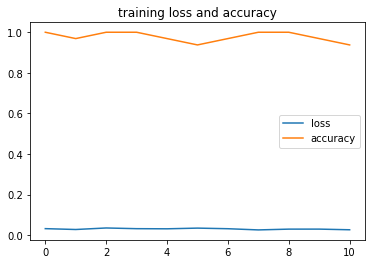

Finished Training


In [0]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []

for epoch in range(epochs):
    acc =0.
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        #outputs = model(inputs)
        outputs = model.forward(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()

        if itr%p_itr == 0:
            pred = torch.argmax(outputs, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss =0

        itr+=1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label = 'accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()
print("Finished Training")

In [0]:
filename_path = 'skpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_path)

test_transform = transforms.Compose([
                                     transforms.Resize((128,128)),
                                     transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

In [0]:
model.eval()
fn_list = []
pred_list = []

for x, fn in testloader:
    with torch.no_grad():
        x = x.cuda()
        output = model.forward(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id": fn_list, "label": pred_list})
submission.to_csv('preds_densenet121.csv', index=False)

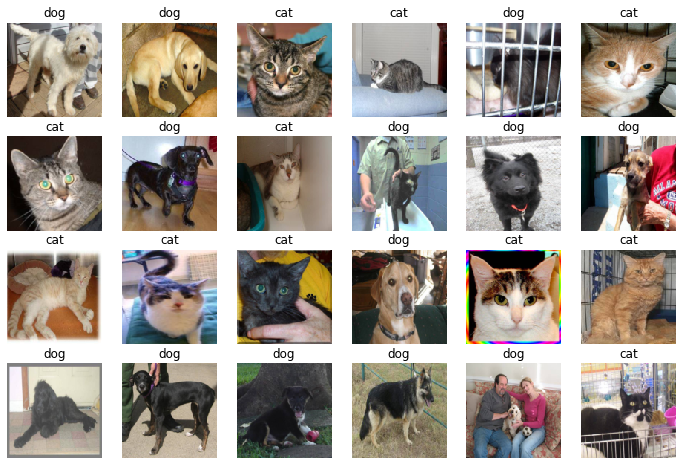

In [0]:
samples, _ = iter(testloader).next()
samples = samples.cuda()
fig = plt.figure(figsize=(12, 8))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))